In [1]:
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
import h2o
from h2o.automl import H2OAutoML
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics as mt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import sys

np.random.seed(1326)
pd.set_option("display.max_columns", None)

# Load and Prep Data

In [2]:
df = pd.read_csv("../datasets/full_dataset.csv")

display(df.info())
display(df.describe())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3112010 entries, 0 to 3112009
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Date                     object 
 1   Lat                      float64
 2   Long                     float64
 3   Total Rainfall Today     float64
 4   Rainfall Duration Today  int64  
 5   Year                     int64  
 6   Department               object 
 7   Municipality             object 
 8   elevation                float64
 9   Forest Loss %            float64
 10  Landslide                int64  
 11  Soil_1                   float64
 12  Soil_2                   float64
 13  Soil_3                   float64
 14  Soil_4                   float64
dtypes: float64(9), int64(3), object(3)
memory usage: 356.1+ MB


None

,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4
count,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06,3.112010e+06
mean,5.550238e+00,-7.463048e+01,6.184781e+00,1.052745e+01,2.013500e+03,1.189075e+03,1.453406e-02,1.200832e-03,4.548845e+00,-7.190569e-01,4.887962e-01,1.950313e-01
std,2.571905e+00,1.703340e+00,9.952174e+00,8.497873e+00,2.291145e+00,9.327786e+02,1.695834e-02,3.463221e-02,4.181527e+01,1.911098e+01,1.268671e+01,9.104870e+00
min,-4.203165e+00,-8.171853e+01,0.000000e+00,0.000000e+00,2.010000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-1.171196e+02,-6.746594e+01,-7.011410e+01,-4.438806e+01
25%,4.216550e+00,-7.576187e+01,4.000000e-01,2.000000e+00,2.012000e+03,2.238231e+02,3.606079e-03,0.000000e+00,-2.593527e+01,-1.283423e+01,-6.150866e+00,-4.736427e+00
50%,5.503838e+00,-7.475520e+01,2.800000e+00,1.000000e+01,2.013000e+03,1.191456e+03,8.837461e-03,0.000000e+00,4.619639e+00,-9.568478e-01,7.023253e-01,-5.830288e-02
75%,6.854309e+00,-7.341802e+01,8.200000e+00,1.700000e+01,2.016000e+03,1.909895e+03,1.889565e-02,0.000000e+00,3.257890e+01,1.138163e+01,7.557220e+00,4.684273e+00
max,1.338142e+01,-6.704646e+01,3.723000e+02,2.400000e+01,2.017000e+03,3.670899e+03,1.590021e-01,1.000000e+00,1.575212e+02,7.973027e+01,4.976447e+01,7.451414e+01


,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,Department,Municipality,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4
0,2010-01-01,-4.203165,-69.935907,0.4,4,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
1,2010-01-02,-4.203165,-69.935907,0.0,0,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
2,2010-01-03,-4.203165,-69.935907,1.6,11,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
3,2010-01-04,-4.203165,-69.935907,6.7,17,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
4,2010-01-05,-4.203165,-69.935907,24.9,24,2010,Amazonas,Leticia,78.378479,0.000479,0,2.921596,-0.724146,-3.821540,-5.245456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112005,2017-12-27,13.381425,-81.365743,1.6,13,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076
3112006,2017-12-28,13.381425,-81.365743,6.2,23,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076
3112007,2017-12-29,13.381425,-81.365743,9.9,23,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076
3112008,2017-12-30,13.381425,-81.365743,2.6,17,2017,San Andrés y Providencia,Providencia,22.483635,0.000564,0,-39.715622,8.102553,-3.819353,1.564076


## Rainfall Lag

In [3]:
RAINFALL_LAG_TERM = 7

df["Total Rainfall Lag"] = (
    df.groupby(["Lat", "Long"])["Total Rainfall Today"]
        .transform(lambda x: x.rolling(5).sum().shift())
        .fillna(0)
)
df["Rainfall Duration Lag"] = (
    df.groupby(["Lat", "Long"])["Rainfall Duration Today"]
        .transform(lambda x: x.rolling(5).sum().shift())
        .fillna(0)
)

df[["Total Rainfall Lag", "Rainfall Duration Lag"]].describe()

,Total Rainfall Lag,Rainfall Duration Lag
count,3.112010e+06,3.112010e+06
mean,3.086774e+01,5.257723e+01
std,3.353258e+01,3.398716e+01
min,0.000000e+00,0.000000e+00
25%,8.100000e+00,2.100000e+01
50%,2.240000e+01,5.400000e+01
75%,4.290000e+01,8.000000e+01
max,6.229000e+02,1.200000e+02


## Subset Data

In [4]:
df_landslide = df[df["Landslide"] == 1]
df_nolandslide = df[df["Landslide"] == 0]

num_landslides = len(df_landslide)
total_records = 100000

if total_records is None:
    df_sample = df.copy()
elif total_records >= num_landslides * 2:
    df_nolandslide = df_nolandslide.sample(n = total_records - num_landslides, random_state = 1326)
    df_sample = pd.concat([ df_landslide, df_nolandslide ], ignore_index = False)
else:
    raise Exception("{} is not enough records for {} landslides".format(total_records, num_landslides))

display(df_sample.describe())
pd.Series.value_counts(df_sample["Landslide"], normalize = True)

,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4,Total Rainfall Lag,Rainfall Duration Lag
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.510049,-74.651570,6.370025,10.677330,2013.481360,1201.592999,0.014448,0.037370,4.633196,-0.768983,0.554234,0.206272,31.366057,53.131560
std,2.561567,1.702368,10.202121,8.551394,2.297987,926.113265,0.016882,0.189668,42.046493,19.142737,12.573357,9.083879,33.405450,34.222836
min,-4.203165,-81.718525,0.000000,0.000000,2010.000000,0.000000,0.000000,0.000000,-117.119598,-67.465938,-70.114099,-44.388061,0.000000,0.000000
25%,4.197542,-75.772477,0.400000,2.000000,2011.000000,236.559692,0.003613,0.000000,-26.018959,-12.834234,-6.091303,-4.736427,8.400000,21.000000
50%,5.467414,-74.773206,2.900000,10.000000,2013.000000,1226.276733,0.008819,0.000000,4.923141,-0.932132,0.737385,-0.056797,23.100000,54.000000
75%,6.773000,-73.433020,8.500000,18.000000,2016.000000,1915.797363,0.018730,0.000000,32.740554,11.305118,7.566346,4.705457,43.800000,81.000000
max,13.381425,-67.046459,317.500000,24.000000,2017.000000,3670.898682,0.159002,1.000000,157.521167,79.730275,49.764472,74.514142,464.200000,120.000000


Landslide
0    0.96263
1    0.03737
Name: proportion, dtype: float64

## Finalize Data

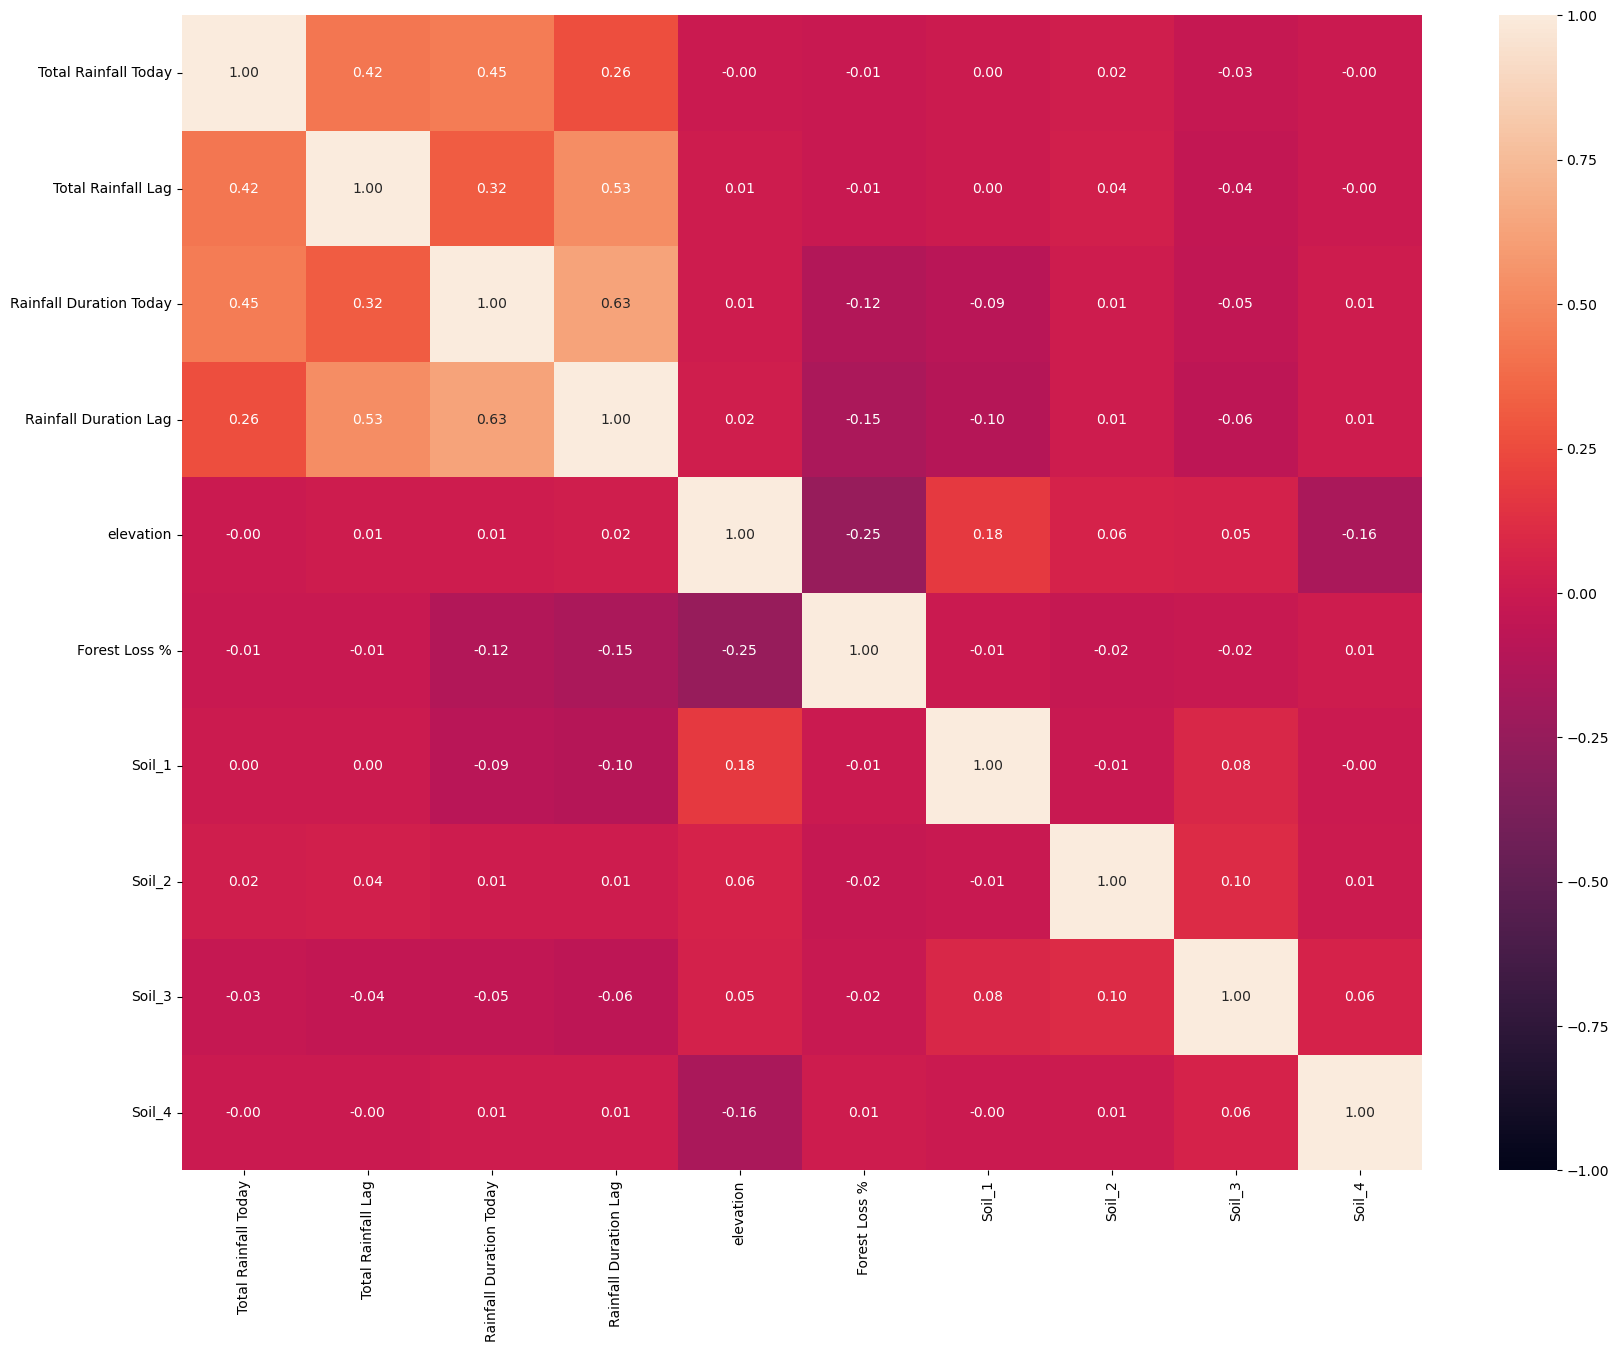

In [5]:
feature_cols = [
    "Total Rainfall Today", "Total Rainfall Lag", "Rainfall Duration Today", "Rainfall Duration Lag",
    "elevation", "Forest Loss %",
    "Soil_1", "Soil_2", "Soil_3", "Soil_4"
]
outcome_col = "Landslide"

df_features = df_sample[feature_cols]

plt.figure(figsize = (20, 15))
sns.heatmap(df_features.corr(), annot=True, fmt=".2f", vmin = -1, vmax = 1)

plt.show()

In [6]:
df_features[outcome_col] = df_sample[outcome_col]

df_train, df_test = train_test_split(df_features, train_size = 0.8, random_state = 1326, stratify = df_features[outcome_col])
df_train.reset_index(drop = True, inplace = True)
df_test.reset_index(drop = True, inplace = True)

print("Training Size:", df_train.shape)
print("Testing Size:", df_test.shape)
print()
print("Training Class Balance:", df_train[outcome_col].value_counts(normalize = True), sep = "\n")
print("Testing Class Balance:", df_test[outcome_col].value_counts(normalize = True), sep = "\n")

Training Size: (80000, 11)
Testing Size: (20000, 11)

Training Class Balance:
Landslide
0    0.962625
1    0.037375
Name: proportion, dtype: float64
Testing Class Balance:
Landslide
0    0.96265
1    0.03735
Name: proportion, dtype: float64



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
scaler = StandardScaler()
df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols].to_numpy())
df_test[feature_cols] = scaler.transform(df_test[feature_cols].to_numpy())

In [8]:
class_weights = compute_class_weight(
    "balanced", classes = np.unique(df_train[outcome_col]), y = df_train[outcome_col]
)
df_train_weighted = df_train.copy()
df_train_weighted["Weight"] = df_train_weighted[outcome_col].map({ 0: class_weights[0], 1: class_weights[1] })
df_train_weighted

,Total Rainfall Today,Total Rainfall Lag,Rainfall Duration Today,Rainfall Duration Lag,elevation,Forest Loss %,Soil_1,Soil_2,Soil_3,Soil_4,Landslide,Weight
0,0.939147,0.062275,-1.014295,-1.404179,0.292354,0.525256,1.262372,0.288014,0.583071,-0.385328,0,0.519413
1,0.744094,0.842059,1.560140,1.169805,-0.387634,-0.295100,1.509469,-0.166605,-0.300692,-0.105102,1,13.377926
2,0.236957,-0.892133,0.741002,-1.082431,-0.043918,-0.773992,1.538492,0.359552,-0.737853,0.725709,0,0.519413
3,-0.231169,0.688510,-0.429196,0.175311,-0.673821,-0.168298,-2.118139,-3.482903,0.953592,-0.842242,0,0.519413
4,-0.572511,0.477758,-1.131315,-1.170180,0.274157,0.130289,0.258133,-0.028259,0.518331,0.294499,0,0.519413
...,...,...,...,...,...,...,...,...,...,...,...,...
79995,1.270736,0.468726,1.560140,1.637802,0.576987,1.340151,-0.903642,-1.432221,-0.864565,-1.675805,0,0.519413
79996,-0.621275,0.510876,-1.248335,-0.321936,-1.261913,0.292455,-0.635525,-0.827286,-1.844452,-0.126942,0,0.519413
79997,-0.621275,-0.910197,-1.248335,-1.316429,1.265754,-0.466165,1.718117,0.468842,2.455442,-0.630232,0,0.519413
79998,-0.621275,-0.940305,-1.248335,-1.550428,0.813407,-0.692993,0.741456,0.082900,-0.874077,0.093297,0,0.519413


In [9]:
rus = RandomUnderSampler(random_state = 1326)

X_rus, y_rus = rus.fit_resample(df_train[feature_cols].to_numpy(), df_train[outcome_col].to_numpy())
df_train_rus = pd.DataFrame()
df_train_rus[feature_cols] = X_rus
df_train_rus[outcome_col] = y_rus
df_train_rus

,Total Rainfall Today,Total Rainfall Lag,Rainfall Duration Today,Rainfall Duration Lag,elevation,Forest Loss %,Soil_1,Soil_2,Soil_3,Soil_4,Landslide
0,-0.621275,-0.919230,-1.248335,-1.345679,0.369234,-0.299683,-0.440536,-0.905726,-0.075908,-1.024848,0
1,-0.621275,-0.831918,-1.248335,-1.433428,0.742560,0.404891,1.962596,0.479247,1.502751,-0.718554,0
2,-0.621275,-0.362241,-1.248335,-0.409685,0.778443,-0.729350,-2.139914,-0.899656,1.309454,0.597132,0
3,0.822115,-0.016005,0.975041,1.345304,1.854568,-0.315710,0.512675,0.788893,0.922256,0.050752,0
4,-0.621275,-0.931273,-1.248335,-1.462678,0.388582,-0.661134,-0.928805,-0.557956,0.141558,-0.436416,0
...,...,...,...,...,...,...,...,...,...,...,...
5975,0.188194,0.309156,1.092061,0.380060,-0.246037,0.074229,-1.608673,-0.197086,0.661857,0.129728,1
5976,2.333773,1.353886,1.560140,0.994306,0.320346,1.519857,1.741687,0.700560,0.413542,0.442662,1
5977,0.471020,0.757758,0.858021,1.813301,1.480589,-0.032389,0.589363,0.460749,0.496493,-0.508550,1
5978,-0.318943,0.718618,0.389942,1.345304,-0.061118,-0.275678,-2.146992,2.492808,-0.723879,-1.145734,1


In [10]:
smote = SMOTE(random_state = 1326)

X_smote, y_smote = smote.fit_resample(df_train[feature_cols].to_numpy(), df_train[outcome_col].to_numpy())
df_train_smote = pd.DataFrame()
df_train_smote[feature_cols] = X_smote
df_train_smote[outcome_col] = y_smote
df_train_smote

,Total Rainfall Today,Total Rainfall Lag,Rainfall Duration Today,Rainfall Duration Lag,elevation,Forest Loss %,Soil_1,Soil_2,Soil_3,Soil_4,Landslide
0,0.939147,0.062275,-1.014295,-1.404179,0.292354,0.525256,1.262372,0.288014,0.583071,-0.385328,0
1,0.744094,0.842059,1.560140,1.169805,-0.387634,-0.295100,1.509469,-0.166605,-0.300692,-0.105102,1
2,0.236957,-0.892133,0.741002,-1.082431,-0.043918,-0.773992,1.538492,0.359552,-0.737853,0.725709,0
3,-0.231169,0.688510,-0.429196,0.175311,-0.673821,-0.168298,-2.118139,-3.482903,0.953592,-0.842242,0
4,-0.572511,0.477758,-1.131315,-1.170180,0.274157,0.130289,0.258133,-0.028259,0.518331,0.294499,0
...,...,...,...,...,...,...,...,...,...,...,...
154015,-0.323986,0.735663,-0.429196,1.823420,0.659377,-0.448841,0.121331,0.527829,-0.052560,0.365526,1
154016,0.834538,0.715311,1.560140,1.374554,1.352573,-0.786595,1.245581,-0.180412,0.148807,-0.823384,1
154017,-0.066738,-0.373047,0.334520,0.173768,-0.649102,-0.339193,0.086581,-1.507321,-0.553563,-0.138616,1
154018,0.139964,0.218107,0.994231,0.305102,0.241482,-0.317327,1.055181,-0.501193,-0.318748,0.577982,1


# Modeling

In [11]:
h2o.init()
h2o_train = h2o.H2OFrame(df_train)
h2o_test = h2o.H2OFrame(df_test)

h2o_train[outcome_col] = h2o_train[outcome_col].asfactor()
h2o_test[outcome_col] = h2o_test[outcome_col].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_401"; Java(TM) SE Runtime Environment (build 1.8.0_401-b10); Java HotSpot(TM) 64-Bit Server VM (build 25.401-b10, mixed mode)
  Starting server from /Users/ryanschaefer/miniconda3/envs/mlenv/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/24/0bddfjxx3258qzvf6pn5md3c0000gn/T/tmprtdha5ra
  JVM stdout: /var/folders/24/0bddfjxx3258qzvf6pn5md3c0000gn/T/tmprtdha5ra/h2o_ryanschaefer_started_from_python.out
  JVM stderr: /var/folders/24/0bddfjxx3258qzvf6pn5md3c0000gn/T/tmprtdha5ra/h2o_ryanschaefer_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_ryanschaefer_zv7fn5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [12]:
aml = H2OAutoML(max_models=15, seed=1326)
aml.train(
    x=feature_cols, y=outcome_col, training_frame=h2o_train, 
    leaderboard_frame=h2o_test
)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),11/15
# GBM base models (used / total),5/6
# XGBoost base models (used / total),5/5
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [13]:
h2o.save_model(aml.leader, "../models/base", force = True)
# View the AutoML Leaderboard
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20240415_184043,0.830572,0.128116,0.23418,0.361795,0.178802,0.0319701,19436,0.02338,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20240415_184043,0.826015,0.12897,0.230053,0.374627,0.179048,0.0320583,19172,0.03094,StackedEnsemble
GBM_4_AutoML_1_20240415_184043,0.819243,0.13139,0.217736,0.356905,0.180247,0.0324889,3989,0.015763,GBM
XGBoost_grid_1_AutoML_1_20240415_184043_model_1,0.818466,0.131431,0.218754,0.33493,0.180335,0.0325205,3925,0.005956,XGBoost
GBM_1_AutoML_1_20240415_184043,0.818186,0.130868,0.222662,0.361714,0.179837,0.0323413,2731,0.016459,GBM
GBM_2_AutoML_1_20240415_184043,0.817245,0.131231,0.218408,0.374396,0.180121,0.0324437,4976,0.020516,GBM
GBM_3_AutoML_1_20240415_184043,0.816767,0.131368,0.216695,0.366272,0.180244,0.0324879,3053,0.016033,GBM
XGBoost_grid_1_AutoML_1_20240415_184043_model_2,0.815426,0.132851,0.206605,0.363105,0.181468,0.0329306,11525,0.006233,XGBoost
XGBoost_1_AutoML_1_20240415_184043,0.815344,0.13329,0.215492,0.362034,0.181157,0.0328179,5732,0.005613,XGBoost
GBM_grid_1_AutoML_1_20240415_184043_model_1,0.814615,0.132279,0.207013,0.361103,0.180787,0.0326838,1055,0.01229,GBM


In [14]:
h2o.init()
h2o_train_smote = h2o.H2OFrame(df_train_smote)
h2o_test = h2o.H2OFrame(df_test)

h2o_train_smote[outcome_col] = h2o_train_smote[outcome_col].asfactor()
h2o_test[outcome_col] = h2o_test[outcome_col].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,5 mins 43 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_ryanschaefer_zv7fn5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.417 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
aml_smote = H2OAutoML(max_models=15, seed=1326)
aml_smote.train(
    x=feature_cols, y=outcome_col, training_frame=h2o_train_smote, 
    leaderboard_frame=h2o_test
)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/6
# GBM base models (used / total),1/1
# XGBoost base models (used / total),1/1
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [16]:
h2o.save_model(aml_smote.leader, "../models/smote", force = True)
# View the AutoML Leaderboard
lb_smote = h2o.automl.get_leaderboard(aml_smote, extra_columns = "ALL")
lb_smote.head(rows=lb_smote.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_BestOfFamily_1_AutoML_2_20240415_184620,0.815288,0.184414,0.211127,0.325066,0.196332,0.0385461,51205,0.086471,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_2_20240415_184620,0.814209,0.184326,0.211338,0.333828,0.195439,0.0381965,57361,0.073797,StackedEnsemble
GBM_1_AutoML_2_20240415_184620,0.805851,0.148933,0.198636,0.346618,0.196286,0.0385283,11083,0.081875,GBM
GBM_2_AutoML_2_20240415_184620,0.80297,0.160245,0.201042,0.378119,0.203988,0.041611,15695,0.09189,GBM
XRT_1_AutoML_2_20240415_184620,0.800962,0.273546,0.174327,0.340408,0.279167,0.077934,4704,0.021818,DRF
DRF_1_AutoML_2_20240415_184620,0.799535,0.277424,0.179959,0.390178,0.280546,0.0787063,2967,0.018351,DRF
XGBoost_3_AutoML_2_20240415_184620,0.799197,0.14578,0.193068,0.330171,0.189573,0.0359378,95501,0.031541,XGBoost
XGBoost_grid_1_AutoML_2_20240415_184620_model_1,0.799081,0.149814,0.191601,0.362952,0.19246,0.0370409,82696,0.028263,XGBoost
GBM_4_AutoML_2_20240415_184620,0.798751,0.149436,0.197495,0.351779,0.195927,0.0383875,11117,0.068312,GBM
GBM_3_AutoML_2_20240415_184620,0.798063,0.157184,0.200782,0.355238,0.201488,0.0405976,13447,0.076759,GBM


In [17]:
h2o.init()
h2o_train_rus = h2o.H2OFrame(df_train_rus)
h2o_test = h2o.H2OFrame(df_test)

h2o_train_rus[outcome_col] = h2o_train_rus[outcome_col].asfactor()
h2o_test[outcome_col] = h2o_test[outcome_col].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 18 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_ryanschaefer_zv7fn5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.186 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [18]:
aml_rus = H2OAutoML(max_models=15, seed=1326)
aml_rus.train(
    x=feature_cols, y=outcome_col, training_frame=h2o_train_rus, 
    leaderboard_frame=h2o_test
)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),11/15
# GBM base models (used / total),6/6
# XGBoost base models (used / total),4/5
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [19]:
h2o.save_model(aml_rus.leader, "../models/rus", force = True)
# View the AutoML Leaderboard
lb_rus = h2o.automl.get_leaderboard(aml_rus, extra_columns = "ALL")
lb_rus.head(rows=lb_rus.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_3_20240415_205924,0.815039,0.525034,0.195118,0.349936,0.420212,0.176578,2052,0.020425,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_3_20240415_205924,0.813367,0.528746,0.193475,0.38671,0.422356,0.178384,2267,0.021131,StackedEnsemble
GBM_2_AutoML_3_20240415_205924,0.807881,0.53817,0.181852,0.379487,0.42742,0.182688,381,0.011086,GBM
GBM_3_AutoML_3_20240415_205924,0.807192,0.537601,0.183753,0.359179,0.426995,0.182325,466,0.012226,GBM
GBM_grid_1_AutoML_3_20240415_205924_model_1,0.80633,0.537948,0.187106,0.377568,0.426398,0.181816,370,0.015928,GBM
XGBoost_3_AutoML_3_20240415_205924,0.80586,0.542226,0.173169,0.327927,0.428212,0.183366,395,0.003399,XGBoost
GBM_1_AutoML_3_20240415_205924,0.804014,0.539128,0.187196,0.375672,0.427194,0.182495,574,0.019413,GBM
GBM_5_AutoML_3_20240415_205924,0.803138,0.545255,0.17395,0.373466,0.430852,0.185633,295,0.011796,GBM
GBM_4_AutoML_3_20240415_205924,0.801069,0.548796,0.169425,0.382234,0.43158,0.186261,302,0.012813,GBM
XGBoost_grid_1_AutoML_3_20240415_205924_model_1,0.799973,0.545874,0.177239,0.345401,0.428849,0.183911,489,0.003897,XGBoost


In [20]:
h2o.init()
h2o_train_weighted = h2o.H2OFrame(df_train_weighted)
h2o_test = h2o.H2OFrame(df_test)

h2o_train_weighted[outcome_col] = h2o_train_weighted[outcome_col].asfactor()
h2o_test[outcome_col] = h2o_test[outcome_col].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 19 mins
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_ryanschaefer_zv7fn5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.161 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [21]:
aml_weighted = H2OAutoML(max_models=15, seed=1326)
aml_weighted.train(
    x=feature_cols, y=outcome_col, training_frame=h2o_train_weighted, 
    leaderboard_frame=h2o_test, weights_column="Weight"
)

AutoML progress: |███████████████████████████████
21:03:12.499: _weights_column param, All base models use weights_column="Weight" but Stacked Ensemble does not. If you want to use the same weights_column for the meta learner, please specify it as an argument in the h2o.stackedEnsemble call.

████████████████
21:03:33.691: _weights_column param, All base models use weights_column="Weight" but Stacked Ensemble does not. If you want to use the same weights_column for the meta learner, please specify it as an argument in the h2o.stackedEnsemble call.

████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),8/15
# GBM base models (used / total),2/6
# XGBoost base models (used / total),5/5
# DRF base models (used / total),1/2
# DeepLearning base models (used / total),0/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [22]:
h2o.save_model(aml_weighted.leader, "../models/weighted", force = True)
# View the AutoML Leaderboard
lb_weighted = h2o.automl.get_leaderboard(aml_weighted, extra_columns = "ALL")
lb_weighted.head(rows=lb_weighted.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_4_20240415_210005,0.828471,0.128916,0.227993,0.344744,0.179279,0.0321408,21021,0.022025,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_4_20240415_210005,0.824646,0.130092,0.21394,0.359556,0.180096,0.0324347,20717,0.027781,StackedEnsemble
GBM_1_AutoML_4_20240415_210005,0.819224,0.359868,0.208888,0.379206,0.333564,0.111265,1155,0.01218,GBM
GBM_2_AutoML_4_20240415_210005,0.81553,0.433878,0.193797,0.376168,0.375542,0.141032,1346,0.014366,GBM
XGBoost_3_AutoML_4_20240415_210005,0.815501,0.45159,0.200031,0.373453,0.386932,0.149717,1975,0.003915,XGBoost
GBM_5_AutoML_4_20240415_210005,0.814529,0.454638,0.197479,0.337372,0.386413,0.149315,1677,0.017419,GBM
GBM_grid_1_AutoML_4_20240415_210005_model_1,0.81386,0.390016,0.202132,0.366296,0.350081,0.122556,821,0.012112,GBM
GBM_4_AutoML_4_20240415_210005,0.811493,0.375661,0.202925,0.374452,0.341767,0.116805,1540,0.01004,GBM
GBM_3_AutoML_4_20240415_210005,0.81067,0.422438,0.196697,0.365393,0.369652,0.136643,1306,0.012547,GBM
XGBoost_grid_1_AutoML_4_20240415_210005_model_2,0.806811,0.323469,0.196423,0.364585,0.319108,0.10183,5648,0.005388,XGBoost


# Evaluate Model Performance

In [23]:
# https://stackoverflow.com/questions/8391411/how-to-block-calls-to-print
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [24]:
# h2o.init()

# h2o_train = h2o.H2OFrame(df_train)
# h2o_test = h2o.H2OFrame(df_test)
# h2o_train[outcome_col] = h2o_train[outcome_col].asfactor()
# h2o_test[outcome_col] = h2o_test[outcome_col].asfactor()

# aml = h2o.load_model("../models/base/StackedEnsemble_AllModels_1_AutoML_1_20240407_185226")
# aml_smote = h2o.load_model("../models/smote/StackedEnsemble_AllModels_1_AutoML_2_20240407_185826")
# aml_rus = h2o.load_model("../models/rus/StackedEnsemble_AllModels_1_AutoML_3_20240407_203149")
# aml_weighted = h2o.load_model("../models/weighted/StackedEnsemble_AllModels_1_AutoML_4_20240407_203253")

In [25]:
df_train_full, df_test_full = train_test_split(df_sample, train_size = 0.8, random_state = 1326, stratify = df_sample[outcome_col])
df_train_full.reset_index(drop = True, inplace = True)
df_test_full.reset_index(drop = True, inplace = True)

df_test_full

,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,Department,Municipality,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4,Total Rainfall Lag,Rainfall Duration Lag
0,2016-07-06,4.521302,-74.593706,87.9,24,2016,Cundinamarca,Apulo,419.584351,0.016138,0,-74.453867,-16.404670,1.096286,-8.000130,322.9,120.0
1,2011-12-08,5.544642,-73.357557,0.7,6,2011,Boyacá,Tunja,2694.833496,0.001619,0,21.131410,5.422564,6.641721,-9.834569,72.3,120.0
2,2013-09-01,8.850104,-76.427089,16.4,20,2013,Antioquia,Arboletes,11.107697,0.030439,1,-43.201976,-6.250748,7.306600,2.834127,65.3,103.0
3,2011-04-10,6.670882,-73.174836,10.6,24,2011,Santander,Villanueva,1455.724976,0.001535,0,-47.631354,31.411992,9.709849,-0.058303,33.0,94.0
4,2013-02-02,6.647003,-75.460450,3.6,4,2013,Antioquia,Santa Rosa de Osos,2581.287109,0.014662,0,67.215435,-13.162816,-2.365418,11.764767,9.1,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2011-04-03,5.062974,-75.502770,9.0,1,2011,Caldas,Manizales,2097.782959,0.012717,0,100.245150,-21.830417,2.644000,1.735833,26.0,34.0
19996,2013-12-20,5.474716,-75.601051,0.0,0,2013,Caldas,Marmato,1344.932129,0.013505,0,8.824292,10.015748,0.216018,2.217352,22.5,14.0
19997,2011-09-18,6.647003,-75.460450,15.4,4,2011,Antioquia,Santa Rosa de Osos,2581.287109,0.006608,0,67.215435,-13.162816,-2.365418,11.764767,21.0,9.0
19998,2012-03-09,6.849736,-75.684091,5.3,16,2012,Antioquia,San José de la Montaña,2589.256104,0.002868,0,38.358650,-20.745913,-23.813387,-14.624855,26.0,69.0


In [26]:
with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    with HiddenPrints():
        df_test_full["Base Probability"] = h2o.as_list(aml.predict(h2o_test)["p1"])
        df_test_full["SMOTE Probability"] = h2o.as_list(aml_smote.predict(h2o_test)["p1"])
        df_test_full["RUS Probability"] = h2o.as_list(aml_rus.predict(h2o_test)["p1"])
        df_test_full["Weighted Probability"] = h2o.as_list(aml_weighted.predict(h2o_test)["p1"])

df_test_full

Test/Validation dataset is missing column 'Weight': substituting in a column of NaN


,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,Department,Municipality,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4,Total Rainfall Lag,Rainfall Duration Lag,Base Probability,SMOTE Probability,RUS Probability,Weighted Probability
0,2016-07-06,4.521302,-74.593706,87.9,24,2016,Cundinamarca,Apulo,419.584351,0.016138,0,-74.453867,-16.404670,1.096286,-8.000130,322.9,120.0,0.105167,2.215131e-03,0.602195,0.079618
1,2011-12-08,5.544642,-73.357557,0.7,6,2011,Boyacá,Tunja,2694.833496,0.001619,0,21.131410,5.422564,6.641721,-9.834569,72.3,120.0,0.342366,6.941786e-01,0.756265,0.262404
2,2013-09-01,8.850104,-76.427089,16.4,20,2013,Antioquia,Arboletes,11.107697,0.030439,1,-43.201976,-6.250748,7.306600,2.834127,65.3,103.0,0.007570,2.160039e-05,0.370871,0.006405
3,2011-04-10,6.670882,-73.174836,10.6,24,2011,Santander,Villanueva,1455.724976,0.001535,0,-47.631354,31.411992,9.709849,-0.058303,33.0,94.0,0.047802,2.761618e-02,0.478556,0.065569
4,2013-02-02,6.647003,-75.460450,3.6,4,2013,Antioquia,Santa Rosa de Osos,2581.287109,0.014662,0,67.215435,-13.162816,-2.365418,11.764767,9.1,7.0,0.018238,6.625882e-04,0.332233,0.013387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2011-04-03,5.062974,-75.502770,9.0,1,2011,Caldas,Manizales,2097.782959,0.012717,0,100.245150,-21.830417,2.644000,1.735833,26.0,34.0,0.565695,9.305516e-01,0.938184,0.419749
19996,2013-12-20,5.474716,-75.601051,0.0,0,2013,Caldas,Marmato,1344.932129,0.013505,0,8.824292,10.015748,0.216018,2.217352,22.5,14.0,0.014903,1.636593e-07,0.219014,0.019508
19997,2011-09-18,6.647003,-75.460450,15.4,4,2011,Antioquia,Santa Rosa de Osos,2581.287109,0.006608,0,67.215435,-13.162816,-2.365418,11.764767,21.0,9.0,0.029629,1.340318e-04,0.503661,0.036326
19998,2012-03-09,6.849736,-75.684091,5.3,16,2012,Antioquia,San José de la Montaña,2589.256104,0.002868,0,38.358650,-20.745913,-23.813387,-14.624855,26.0,69.0,0.010238,5.548392e-04,0.211575,0.011234


In [27]:
model_names = ["Base", "SMOTE", "RUS", "Weighted"]
actual = df_test_full[outcome_col].to_numpy()
beta2 = 4. ** 2
best_thresholds = []

for i, model in enumerate(model_names):
    probs = df_test_full["{} Probability".format(model)].to_numpy()

    ### https://datascience.stackexchange.com/questions/96690/how-to-choose-the-right-threshold-for-binary-classification
    # calculate pr curve
    precision, recall, thresholds = mt.precision_recall_curve(actual, probs)

    # convert to f-beta score
    fscore = ((1 + beta2) * precision * recall) / (beta2 * precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    best_thresholds.append(thresholds[ix])
        
pd.DataFrame({
    "Model": model_names,
    "Threshold": best_thresholds
})

invalid value encountered in divide


,Model,Threshold
0,Base,0.958286
1,SMOTE,0.003105
2,RUS,0.477222
3,Weighted,0.033605


In [28]:
for i, model in enumerate(model_names):
    probs_col = "{} Probability".format(model)
    preds_col = "{} Prediction".format(model)
    
    df_test_full[preds_col] = (df_test_full[probs_col] > best_thresholds[i]).astype(int)
   
df_test_full.to_csv("../datasets/model_predictions.csv", index = False) 
df_test_full.head()

,Date,Lat,Long,Total Rainfall Today,Rainfall Duration Today,Year,Department,Municipality,elevation,Forest Loss %,Landslide,Soil_1,Soil_2,Soil_3,Soil_4,Total Rainfall Lag,Rainfall Duration Lag,Base Probability,SMOTE Probability,RUS Probability,Weighted Probability,Base Prediction,SMOTE Prediction,RUS Prediction,Weighted Prediction
0,2016-07-06,4.521302,-74.593706,87.9,24,2016,Cundinamarca,Apulo,419.584351,0.016138,0,-74.453867,-16.404670,1.096286,-8.000130,322.9,120.0,0.105167,0.002215,0.602195,0.079618,0,0,1,1
1,2011-12-08,5.544642,-73.357557,0.7,6,2011,Boyacá,Tunja,2694.833496,0.001619,0,21.131410,5.422564,6.641721,-9.834569,72.3,120.0,0.342366,0.694179,0.756265,0.262404,0,1,1,1
2,2013-09-01,8.850104,-76.427089,16.4,20,2013,Antioquia,Arboletes,11.107697,0.030439,1,-43.201976,-6.250748,7.306600,2.834127,65.3,103.0,0.007570,0.000022,0.370871,0.006405,0,0,0,0
3,2011-04-10,6.670882,-73.174836,10.6,24,2011,Santander,Villanueva,1455.724976,0.001535,0,-47.631354,31.411992,9.709849,-0.058303,33.0,94.0,0.047802,0.027616,0.478556,0.065569,0,1,1,1
4,2013-02-02,6.647003,-75.460450,3.6,4,2013,Antioquia,Santa Rosa de Osos,2581.287109,0.014662,0,67.215435,-13.162816,-2.365418,11.764767,9.1,7.0,0.018238,0.000663,0.332233,0.013387,0,0,0,0


In [29]:
for model in model_names:
    preds = df_test_full["{} Prediction".format(model)]
    print(model)
    print(mt.confusion_matrix(actual, preds))
    print(mt.classification_report(actual, preds))

Base
[[19253     0]
 [  747     0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     19253
           1       0.00      0.00      0.00       747

    accuracy                           0.96     20000
   macro avg       0.48      0.50      0.49     20000
weighted avg       0.93      0.96      0.94     20000

SMOTE
[[13346  5907]
 [  155   592]]
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     19253
           1       0.09      0.79      0.16       747

    accuracy                           0.70     20000
   macro avg       0.54      0.74      0.49     20000
weighted avg       0.96      0.70      0.79     20000

RUS
[[13614  5639]
 [  171   576]]
              precision    recall  f1-score   support

           0       0.99      0.71      0.82     19253
           1       0.09      0.77      0.17       747

    accuracy                           0.71     20000
   macro avg       0

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


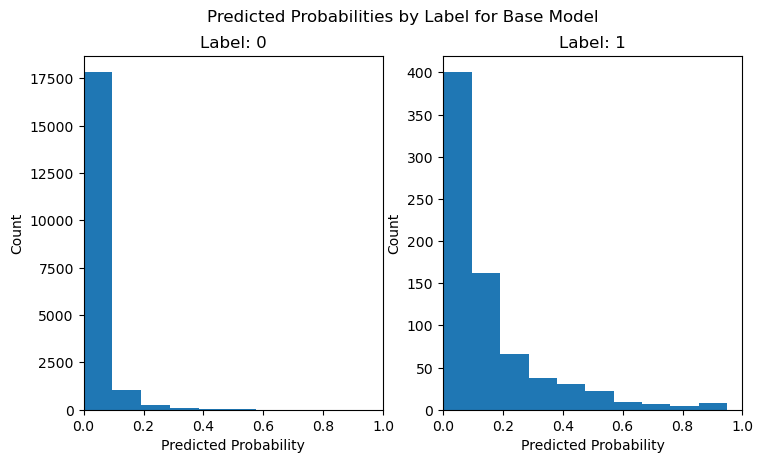

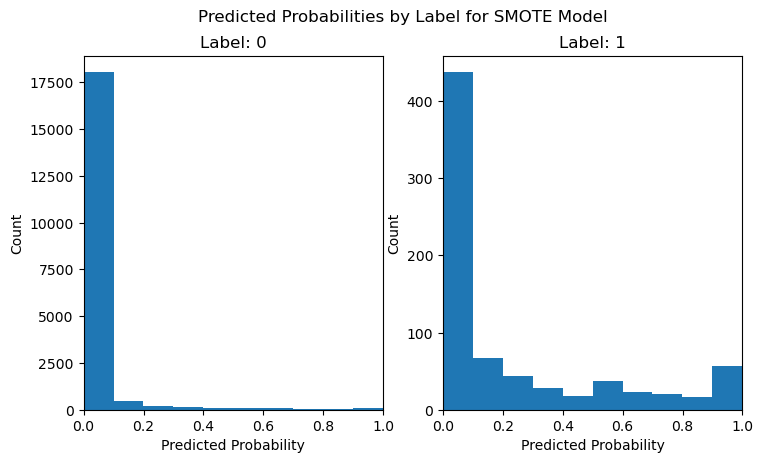

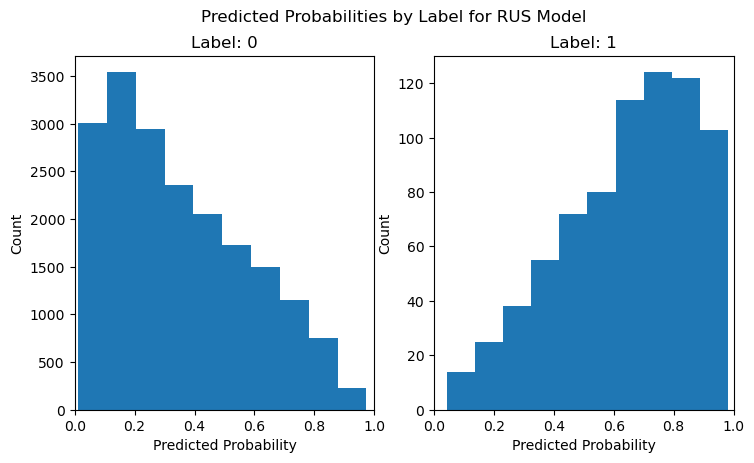

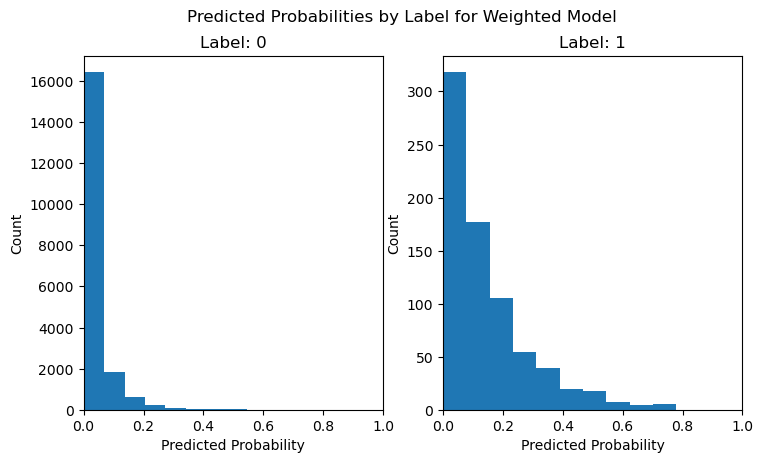

In [30]:
for i, name in enumerate(model_names):
    probs_col = "{} Probability".format(name)
    
    plt.figure(figsize=(1.7 * 5, 2.3 * 2))
    plt.suptitle("Predicted Probabilities by Label for {} Model".format(name))
    for label in [0, 1]:
        df_temp = df_test_full[df_test_full[outcome_col] == label]
        plt.subplot(1, 2, label + 1)
        plt.hist(df_temp[probs_col])
        plt.title("Label: {}".format(label))
        plt.xlim((0, 1))
        plt.xlabel("Predicted Probability")
        plt.ylabel("Count")
        
    plt.show()

In [31]:
class FBeta:
    def __init__(self, beta):
        self.beta = beta
        
    def score(self, y, yhat):
        return mt.fbeta_score(y, yhat, beta = self.beta)

fbeta = FBeta(4)
metrics = {
    "ROC": mt.roc_auc_score,
    "Accuracy": mt.accuracy_score,
    "Balanced Accuracy": mt.balanced_accuracy_score,
    "Precision": mt.precision_score,
    "Recall": mt.recall_score,
    "F1": mt.f1_score,
    "F-Beta": fbeta.score
}
scores = np.zeros((4, 7))
for i, name in enumerate(model_names):
    actual = df_test_full[outcome_col].to_numpy()
    probs = df_test_full["{} Probability".format(name)].to_numpy()
    preds = df_test_full["{} Prediction".format(name)].to_numpy()
    for j, scorer in enumerate(metrics.values()):
        if j == 0:
            scores[(i, j)] = scorer(actual, probs)
        else:
            scores[(i, j)] = scorer(actual, preds)
            
df_scores = pd.DataFrame({
    "Model": model_names
})
df_scores[list(metrics.keys())] = scores

df_scores

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,Model,ROC,Accuracy,Balanced Accuracy,Precision,Recall,F1,F-Beta
0,Base,0.830618,0.96265,0.500000,0.000000,0.000000,0.000000,0.000000
1,SMOTE,0.816739,0.69690,0.742847,0.091091,0.792503,0.163400,0.545445
2,RUS,0.815048,0.70950,0.739097,0.092679,0.771084,0.165470,0.538999
3,Weighted,0.828429,0.70015,0.752256,0.093527,0.808568,0.167661,0.557740


# Model Interpretation

In [32]:
class H2OClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_cols, seed = 1, max_models = 10, classifier = None, threshold = 0.5):
        self.feature_cols = feature_cols
        self.seed = seed
        self.max_models = max_models
        self.classifier = classifier
        self.threshold = threshold
        
    def fit(self, X, y):
        X = pd.DataFrame(X, columns = self.feature_cols)
        df = h2o.H2OFrame(X)
        df["Target"] = y
        df["Target"] = df["Target"].asfactor()
        self.classifier = H2OAutoML(seed = self.seed, max_models = self.max_models)
        self.classifier.train(y = "Target", training_frame = y)
        return self
    
    def predict(self, X):
        if self.classifier == None:
            raise Exception("Model not trained")
        
        if self.threshold == None:
            X = pd.DataFrame(X, columns = self.feature_cols)
            df = h2o.H2OFrame(X)
            preds = self.classifier.predict(df)
            with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
                return preds.as_data_frame()["predict"].values
        else:
            return (self.predict_proba(X) > self.threshold).astype(int)
    
    def predict_proba(self, X):
        if self.classifier == None:
            raise Exception("Model not trained")
        X = pd.DataFrame(X, columns = self.feature_cols)
        df = h2o.H2OFrame(X)
        preds = self.classifier.predict(df)
        with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
            return preds.as_data_frame()["p1"].values

## ALE

In [33]:
with HiddenPrints():
    model = H2OClassifier(feature_cols, classifier = aml, threshold = best_thresholds[0])
    ale = ALE(model.predict_proba, feature_cols)
    exp_train = ale.explain(df_train[feature_cols].to_numpy())
    exp_test = ale.explain(df_test[feature_cols].to_numpy())

KeyboardInterrupt: 

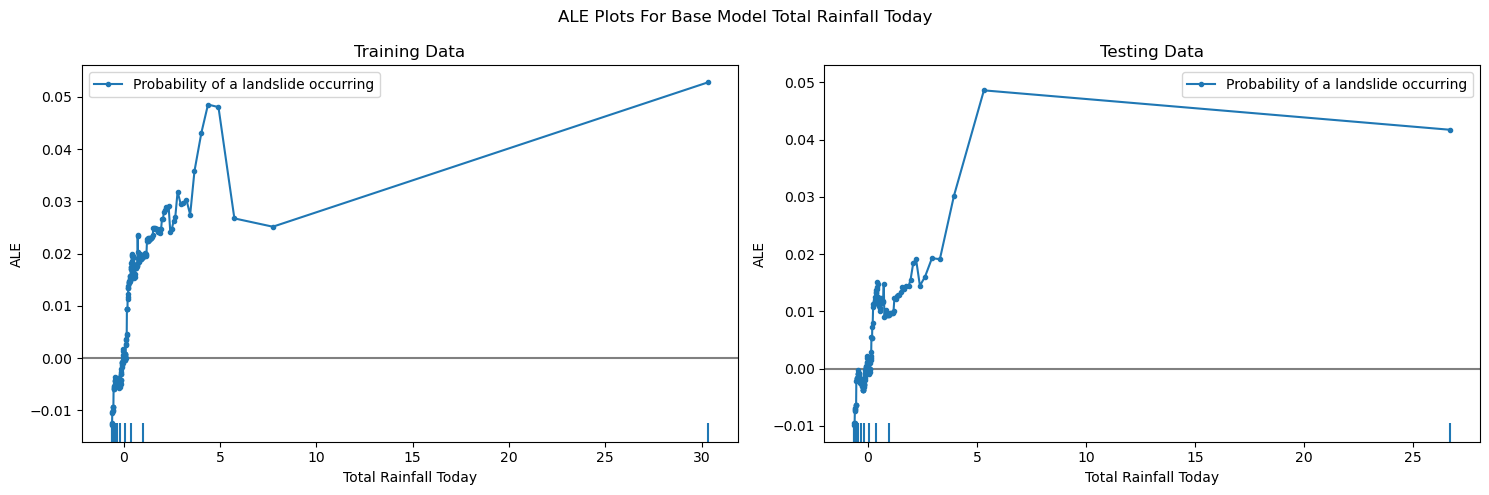

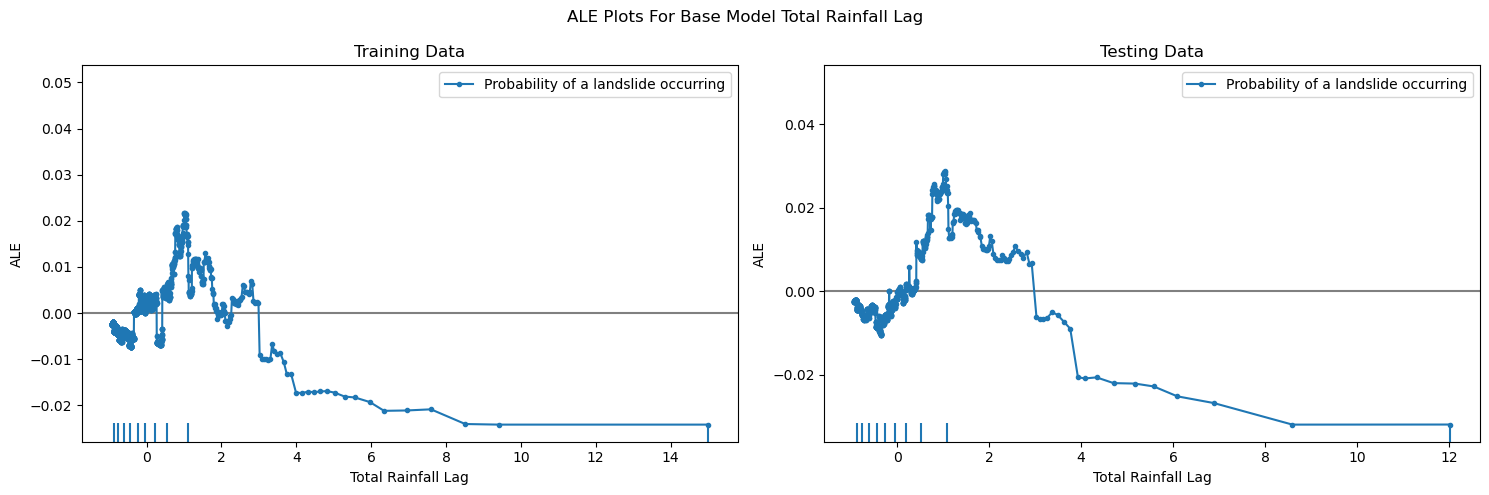

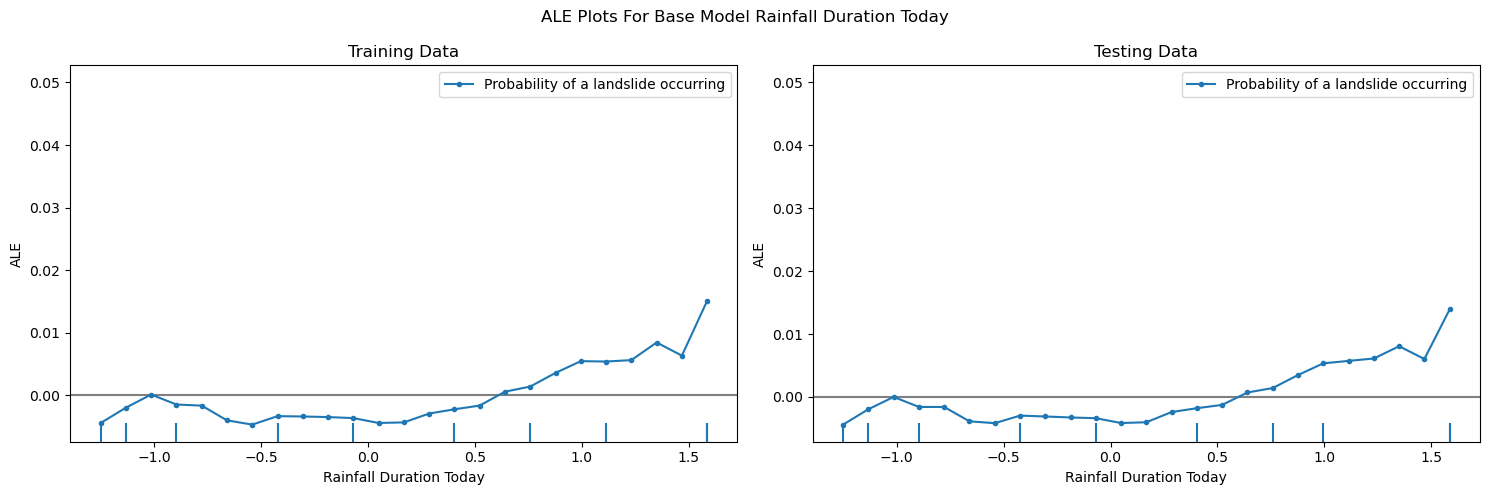

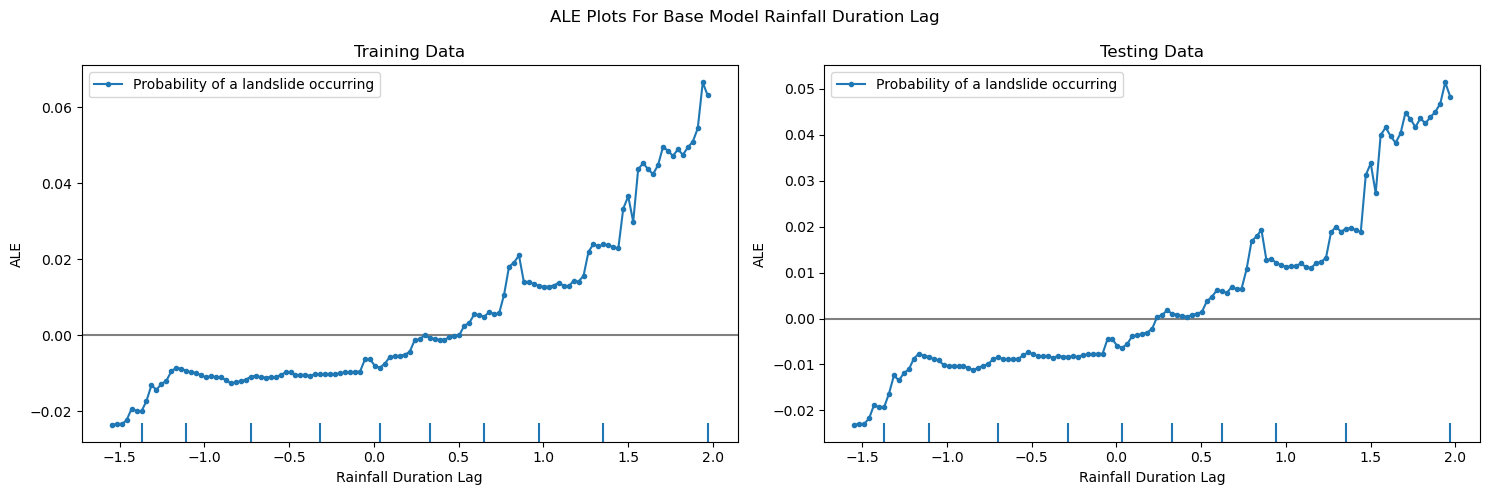

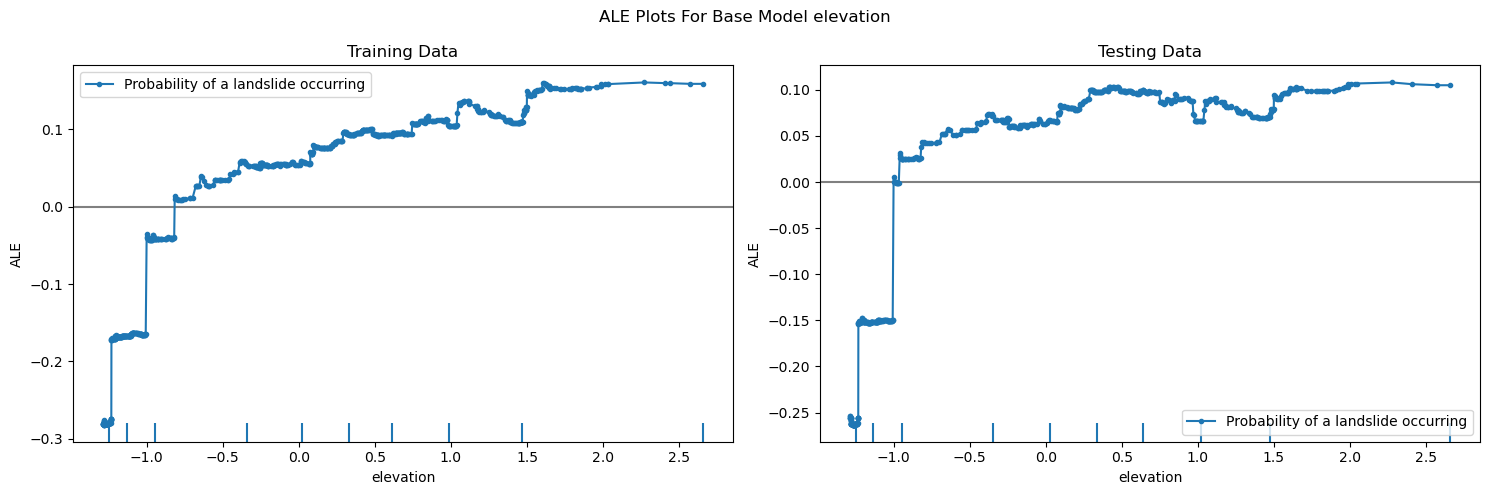

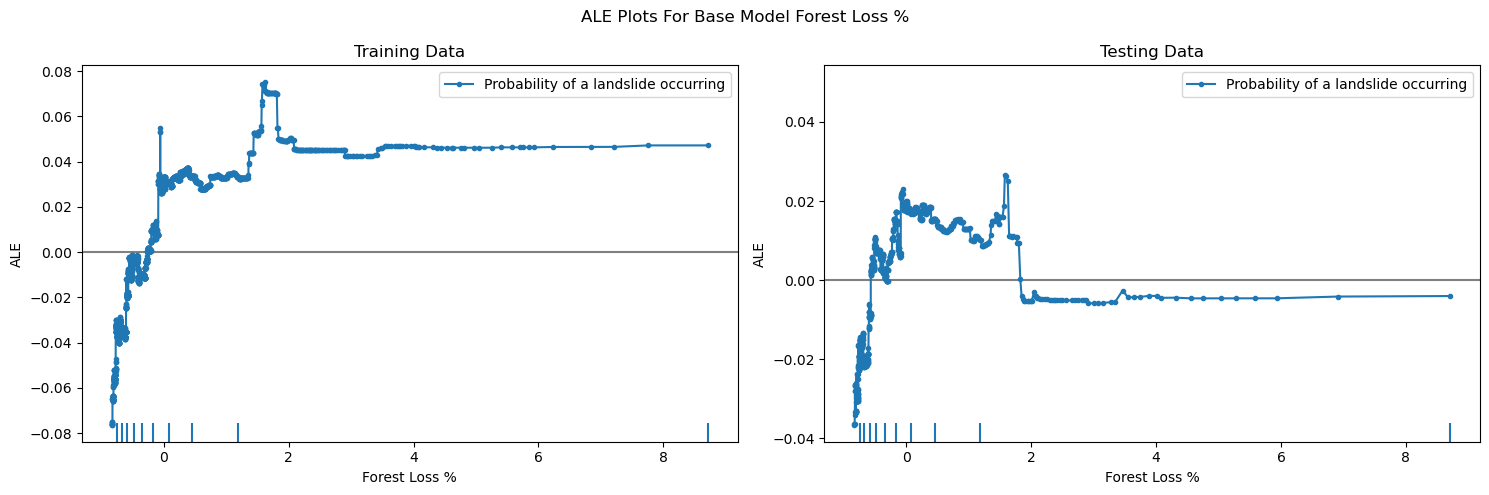

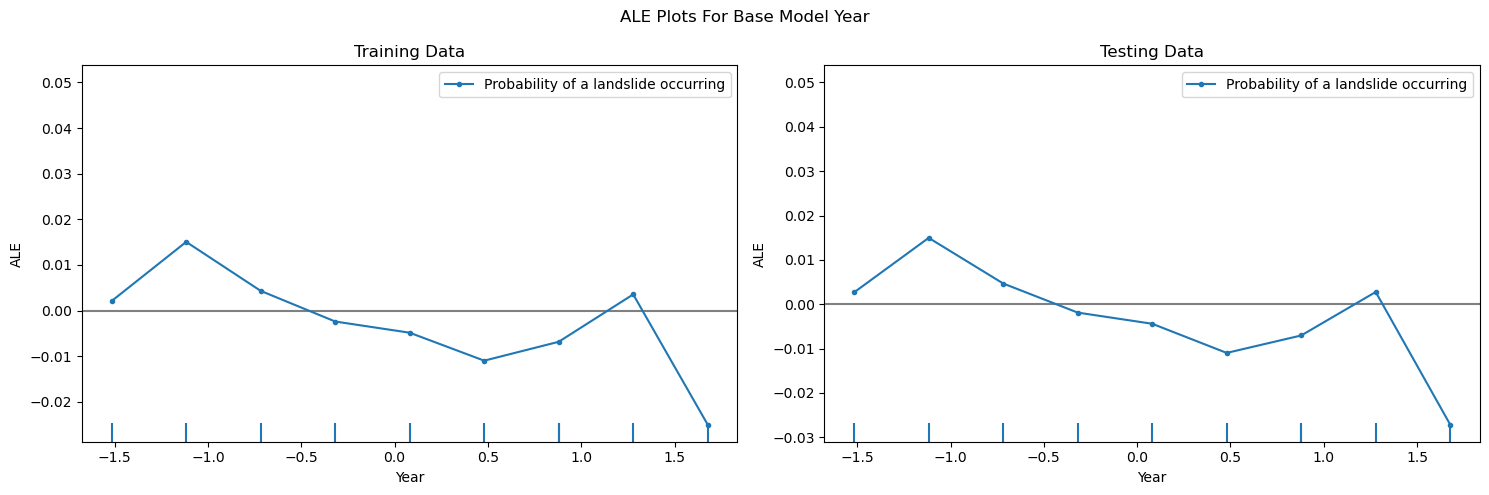

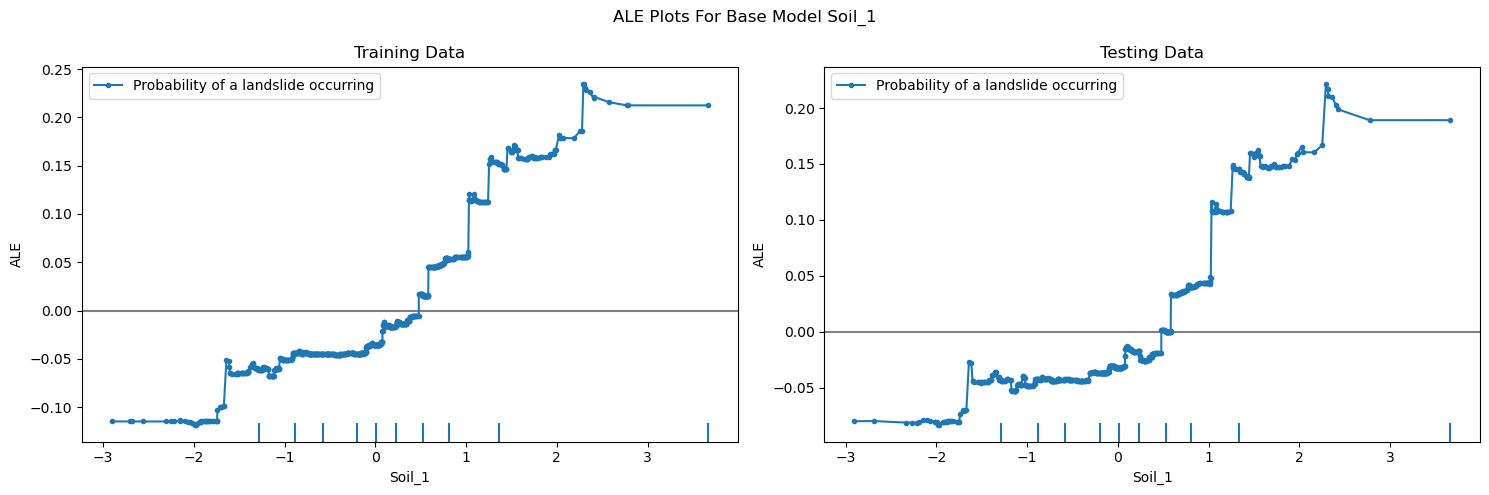

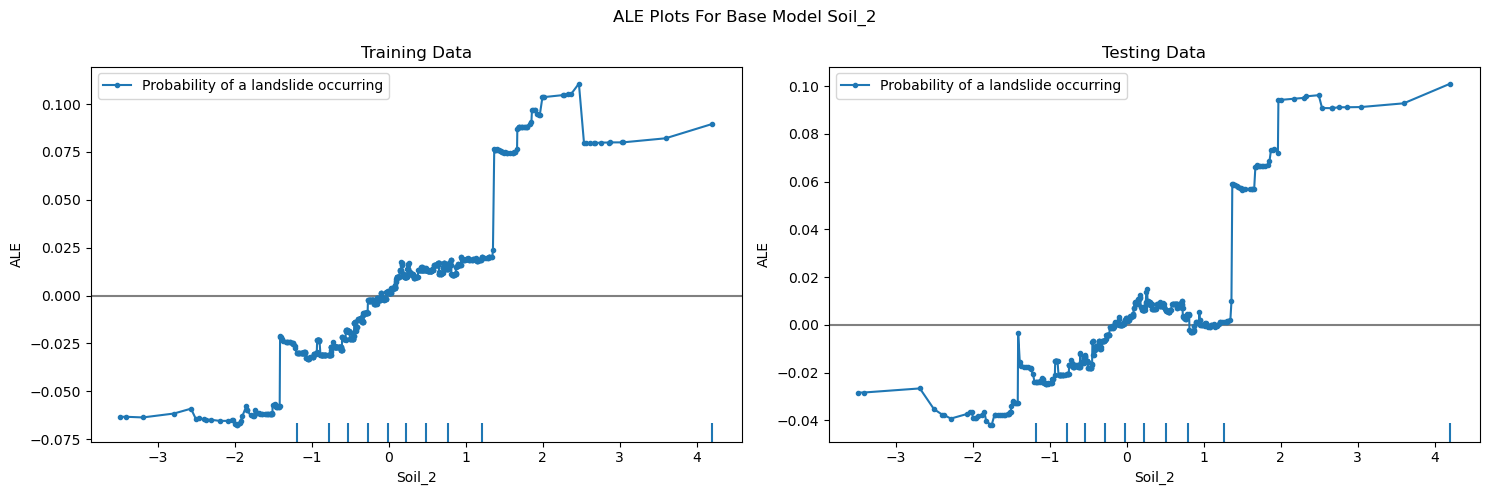

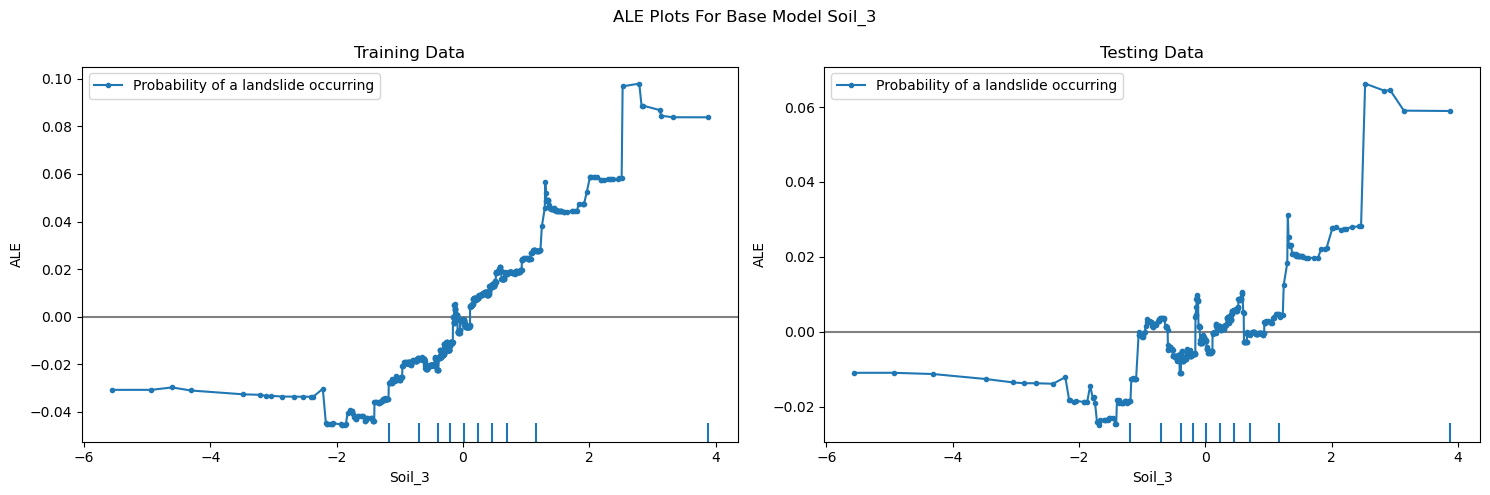

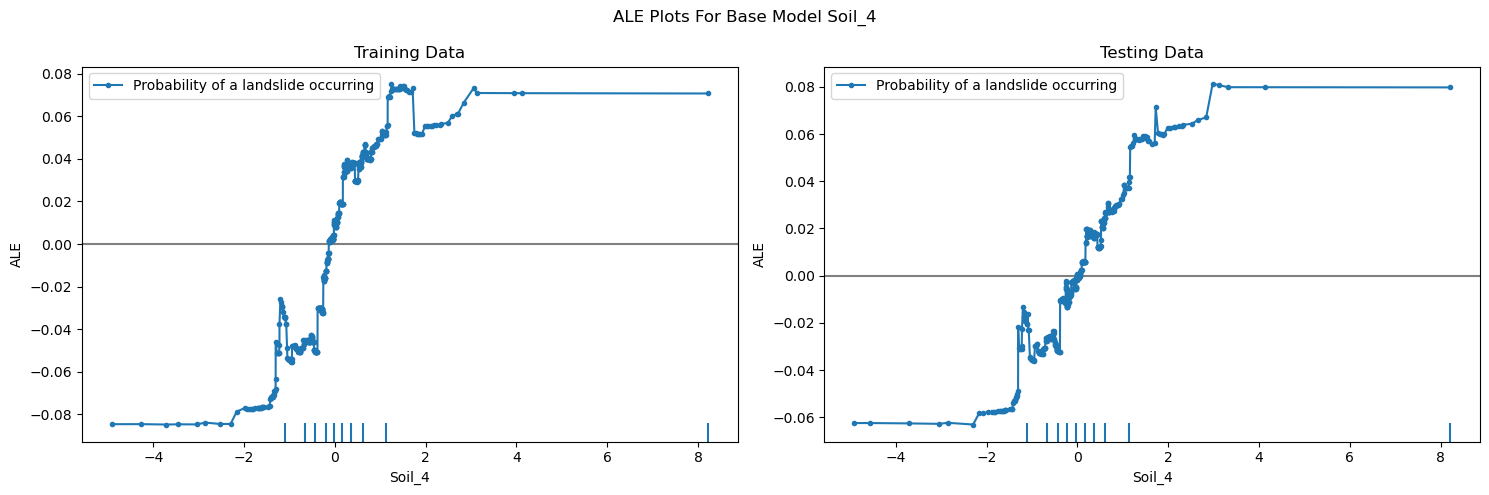

In [ ]:
for feature in feature_cols:
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    fig.suptitle("ALE Plots For Base Model {}".format(feature))
    
    plot_ale(exp_train, features=[feature], line_kw={'label': 'Probability of a landslide occurring'}, ax = ax[0])
    ax[0].set_title("Training Data")
    
    plot_ale(exp_test, features=[feature], line_kw={'label': 'Probability of a landslide occurring'}, ax = ax[1])
    ax[1].set_title("Testing Data")
    
    plt.show()